# GPT 2 ARCHITECTURE: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

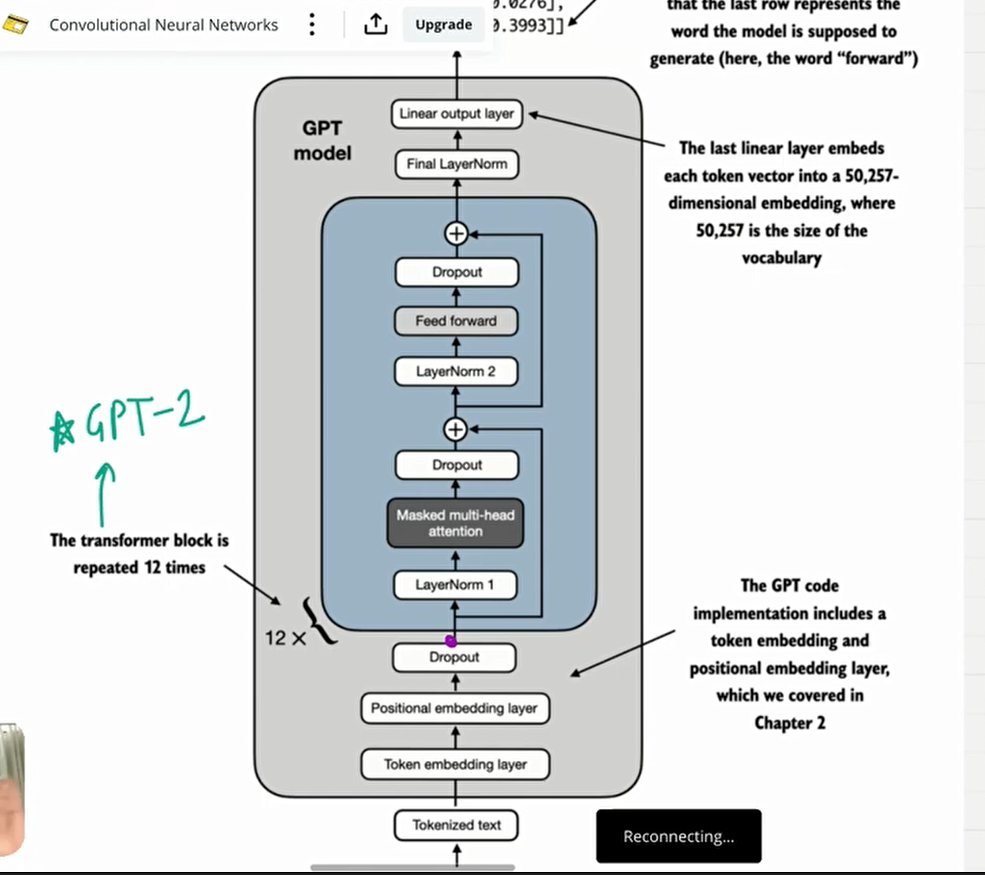

In [8]:
import torch.nn as nn
class layerNorm(nn.Module):
    def __init__(self, emd_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emd_dim)) 
        self.shift = nn.Parameter(torch.zeros(emd_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift

In [9]:
import torch
import torch.nn as nn
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.004715 * torch.pow(x, 3))
        ))

In [10]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # Expansion
            GELU(), # Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ffn = FeedForward(cfg)
        self.norm1 = layerNorm(cfg["emb_dim"])
        self.norm2 = layerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # Shape [batch_size, num_tokens, emb_dim]
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ffn(x) # Shape [batch_size, num_tokens, emb_dim]
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back
        return x

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout=0.1, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_in = d_in
        self.d_out = d_out
        self.context_length = context_length
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.qkv_proj = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.attn_dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=-1)

        # Causal mask to ensure that attention is only applied to previous tokens in the sequence
        self.register_buffer("mask", torch.tril(torch.ones(context_length, context_length)).unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        assert seq_length <= self.context_length, "Sequence length exceeds context length"

        # Project input to query, key, and value tensors
        qkv = self.qkv_proj(x)  # Shape [batch_size, seq_length, 3 * d_out]
        qkv = qkv.view(batch_size, seq_length, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # Shape [3, batch_size, num_heads, seq_length, head_dim]
        queries, keys, values = qkv[0], qkv[1], qkv[2]  # Each of shape [batch_size, num_heads, seq_length, head_dim]

        # Compute scaled dot-product attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim).float())
        scores = scores.masked_fill(self.mask[:, :, :seq_length, :seq_length] == 0, float('-inf'))
        attn_weights = self.softmax(scores)  # Shape [batch_size, num_heads, seq_length, seq_length]
        attn_weights = self.attn_dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, values)    # Shape [batch_size, num_heads, seq_length, head_dim]
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_out)  # Shape [batch_size, seq_length, d_out]
        output = self.out_proj(attn_output)  # Shape [batch_size, seq_length, d_out]
        return output

import torch
def print_gradients(model, sample_input):
    model.zero_grad()  # Clear previous gradients
    output = model(sample_input)  # Forward pass
    loss = output.sum()  # Simple loss function (sum of outputs)
    loss.backward()  # Backward pass to compute gradients

    print("Gradients for each layer:")
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            print(f"{name}: {param.grad}")
        else:
            print(f"{name}: No gradient")






In [13]:
torch.manual_seed(123) # Specify random seed for the initial weights for reproducibility
x = torch.randn(2, 4, 768) # Shape [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x) # Shape [batch_size, num_tokens, emb_dim]
print("Input shape:", x.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [20]:
import torch.nn as nn
import torch
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = layerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [30]:
import torch
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
batch = torch.randint(0, GPT_CONFIG_124M['vocab_size'], (2, 4)) # Shape [batch_size, seq_length]
out = model(batch)
print("Input batch:\n", batch)
print("Model output:\n", out.shape)

Input batch:
 tensor([[25371, 42188, 47556,  8856],
        [13224, 29264, 30628,  7204]])
Model output:
 torch.Size([2, 4, 50257])


In [29]:
# import torch
# torch.manual_seed(123)
# model = GPTModel(GPT_CONFIG_124M)
# out = model(batch)
# print("Input batch:\n", batch)
# print("Model output:\n", out.shape)
# print(out)

In [31]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 163009536


In [34]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Total number of parameters in GPT-2 (excluding output layer): {total_params_gpt2}")
# GPT-2 Model Implementation in PyTorch

Total number of parameters in GPT-2 (excluding output layer): 124412160


In [32]:
print("Token Embedding weights shape:", model.tok_emb.weight.shape)
print("Output layer weights shape:", model.out_head.weight.shape)

Token Embedding weights shape: torch.Size([50257, 768])
Output layer weights shape: torch.Size([50257, 768])


In [33]:
total_size_bytes = total_params * 4  # Assuming 4 bytes per parameter (float32)
print(f"Total size of the model in memory: {total_size_bytes / (1024 ** 2):.2f} MB")
# GPT-2 Model Implementation in PyTorch 

Total size of the model in memory: 621.83 MB
